In [154]:
%pylab inline
import seaborn as sns
sns.set_context(context="talk", font_scale=1)
#  “paper”, “talk”, and “poster”, 
# which are version of the "notebook" parameters scaled by .8, 1.3, and 1.6,
import time
def sec_to_ms(t):
    m = int(t/60)
    s = t%60
    return str(m)+":"+str(s)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# DEFAULT PARAMETERS
# growth rate (or growth half-life time) equals 1

# Initial population
n0 = 100
# Time of growth
Tg = 6
# Mean duration of antibiotic
mTa = 3
# Std in duration of antibiotic
sTa = 0
# Mean lag time
mTs = 3
# Std in lag times
sTs = 0

In [4]:
def growth_det(t, N0=1):
    '''
    Grow cells exponentially for a time t
        t: Growth time
        N0: Initial population
    '''
    return N0*np.exp(t)

def sample_Ts(mTs=mTs, sTs=sTs, size=1, use_cv = False):
    '''
    Sample lag times for the initial population according to a Gaussian distribution of lag times
        mTs: Mean lag time
        sTs: Standard deviation of lag times
        size: Initial population number
    '''
    if use_cv:
        return np.random.normal(loc=mTs, scale=sTs*mTs, size=size)
    else:
        return np.random.normal(loc=mTs, scale=sTs, size=size)

def sample_Ta(mTa=mTa, sTa=sTa, use_cv = False):
    '''
    Sample times of AB exposure for one round of growth according to a normal distribution
        mTa: Mean duration of AB
        sTs: Standard deviation of the duration of AB
    '''
    if use_cv:
        return np.random.normal(loc=mTa, scale=sTa*mTa)
    else:
        return np.random.normal(loc=mTa, scale=sTa)

def single_growth_cycle_stoch(Ts, ta, tg):
    '''
    Runs a single growth cycle for a given set of lag times Ts, a sampled AB duration ta,
    and a growth time tg
        Ts (array-like): List of lag times
        ta: antibiotic duration
        tg: growth time
    '''
    # select survivors i.e. cells for which Ts > Ta
    Ts_surv = Ts[np.where(Ts > ta)[0]]
    n_surv = len(Ts_surv)
    # select the cells that survived and started growing early enough to grow
    Ts_grow = Ts_surv[np.where(Ts_surv < ta+tg)[0]]
    n_grow = len(Ts_grow)
    # The ones that survived the AB but did not start growing only add 1 to the final count
    n_ngrow = n_surv - n_grow
    n = n_ngrow
    # Each parent cell contributes with a lineage that grows exponentially for a time tg-ts
    for ts in Ts_grow:
        n += growth_det(t=tg-ts)
    return n, n_surv, n_ngrow

def many_growth_cycles_stochTa_full(mTs, sTs, mTa, sTa, k=1000, n0=1000, tg=3, use_cvss = False,
                                   use_cva = False):
    '''
    Run many growth cycles given the statistics for lag and AB times.
    At each cycle, lag times and AB times are sampled
    FULL_VERSION: Returns the entire array of final population
    '''
    N = np.zeros(k)
    N_surv = np.zeros(k)
    N_ngrow = np.zeros(k)
    for i in range(k):
        ta = sample_Ta(mTa=mTa, sTa=sTa, use_cv = use_cva)
        Ts = sample_Ts(mTs=mTs, sTs=sTs, size=n0, use_cv=use_cvs)
        N[i], N_surv[i], N_ngrow[i] = single_growth_cycle_stoch(Ts=Ts, ta=ta, tg=tg)
    return N, N_surv, N_ngrow

def many_growth_cycles_stochTa_short(mTs, sTs, mTa, sTa, k=1000, n0=1000, tg=3, use_cvs = False,
                                    use_cva = False):
    '''
    Run many growth cycles given the statistics for lag and AB times.
    At each cycle, lag times and AB times are sampled
    SHORT_VERSION: Returns the means and variances of the final population
    '''
    n_sum, n_surv_sum, n_ngrow_sum = 0, 0, 0
    n2_sum, n_surv2_sum, n_ngrow2_sum = 0, 0, 0
    
    for _ in range(k):
        ta = sample_Ta(mTa=mTa, sTa=sTa, use_cv=use_cva)
        Ts = sample_Ts(mTs=mTs, sTs=sTs, size=n0, use_cv = use_cvs)
        n, n_surv, n_ngrow = single_growth_cycle_stoch(Ts=Ts, ta=ta, tg=tg)
        
        n_sum, n_surv_sum, N_grow_sum = n_sum+n, n_surv_sum+n_surv, n_ngrow_sum+n_ngrow
        n2_sum, n_surv2_sum, n_ngrow2_sum = n2_sum+n**2, n_surv2_sum+n_surv**2, n_ngrow2_sum+n_ngrow**2
            
    mN, mN_surv, mN_ngrow = n_sum/k, n_surv_sum/k, n_ngrow_sum/k
    vN, vN_surv, vN_ngrow = n2_sum/k-mN**2, n_surv2_sum/k-mN_surv**2, n_ngrow2_sum/k-mN_ngrow**2
    return mN, mN_surv, mN_ngrow, vN, vN_surv, vN_ngrow

def sample_Ts_statistics(MTs, STs, mTa, sTa, k=1000, n0=1000, tg=3, use_cvs = False, use_cva=False):
    '''
    Run many growth cycles FOR DIFFERENT VALUES OF THE
    STATISTICS FOR THE LAG TIMES. 
    SHORT_VERSION: Returns the entire array of final population
    '''
    # TODO: Initialize arrays to store what you want
    MN = np.zeros((len(MTs), len(STs)))
    VN = np.zeros((len(MTs), len(STs)))
    for i in range(len(MTs)):
        mTs = MTs[i]
        for j in range(len(STs)):
            sTs = STs[j]
            # TODO: Modify to keep what you want
            mN, _, _, vN, _, _ = many_growth_cycles_stochTa_short(mTs=mTs, sTs=sTs, mTa=mTa,
                                                                  sTa=sTa, k=k, n0=n0, tg=tg,
                                                                 use_cvs=use_cvs, use_cva=use_cva)
            MN[i,j] = mN
            VN[i,j] = vN
    return MN, VN

def sample_Ts_long(MTs, STs, mTa, sTa, k=1000, n0=1000, tg=3, use_cvs=False, use_cva=False):
    '''
    Run many growth cycles FOR DIFFERENT VALUES OF THE
    STATISTICS FOR THE LAG TIMES.
    LONG_VERSION: Returns the entire array of final population
    Returns:
        
    '''
    # TODO: Initialize arrays to store what you want
    NN, N_SURV, N_NGROW = np.zeros((len(MTs), len(STs), k)), np.zeros((len(MTs), len(STs), k)), np.zeros((len(MTs), len(STs), k))
    for i in range(len(MTs)):
        mTs = MTs[i]
        for j in range(len(STs)):
            sTs = STs[j]
            # TODO: Modify to keep what you want
            N, N_surv, N_ngrow = many_growth_cycles_stochTa_full(mTs=mTs, sTs=sTs, mTa=mTa,
                                                                  sTa=sTa, k=k, n0=n0, tg=tg,
                                                                use_cvs=use_cvs, use_cva=use_cva) 
            NN[i,j,:] = N
            N_SURV[i,j,:] = N_surv
            N_NGROW[i,j,:] = N_ngrow
            
    return NN, N_SURV, N_NGROW

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


Text(0.5,0,'Mean lag')

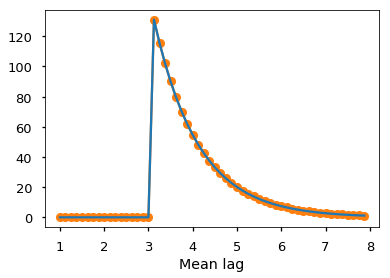

In [29]:
MTs = np.arange(1,8,0.125)
STs = [0]
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa, k=1000, n0=100, tg=8)
plt.errorbar(MTs, MN/n0, np.sqrt(VN)/n0)
plt.plot(MTs, MN/n0, 'o-')
plt.xlabel('Mean lag')

In [9]:
# A good question would be: What is the difference in fitness under the same statistics
# for different tg?

# DEFAULT PARAMETERS
# growth rate (or growth half-life time) equals 1

# Initial population
# n0 = 1000
# tg = 8
# mTa = 3
# sTa = 0
# mTs = 3
# sTs = 0

In [174]:
## RUN THE SIMULATIONS!!
MTs = np.arange(1,8,0.05)
STs = np.arange(0,2,0.05)
# STs = [0, 0.05, 0.25, 0.5, 1, 2]
start = time.time()
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa=0, k=1000, n0=100, tg=8)
end = time.time()
print(sec_to_ms(end-start))

27:51.77242612838745


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,0,'Mean lag')

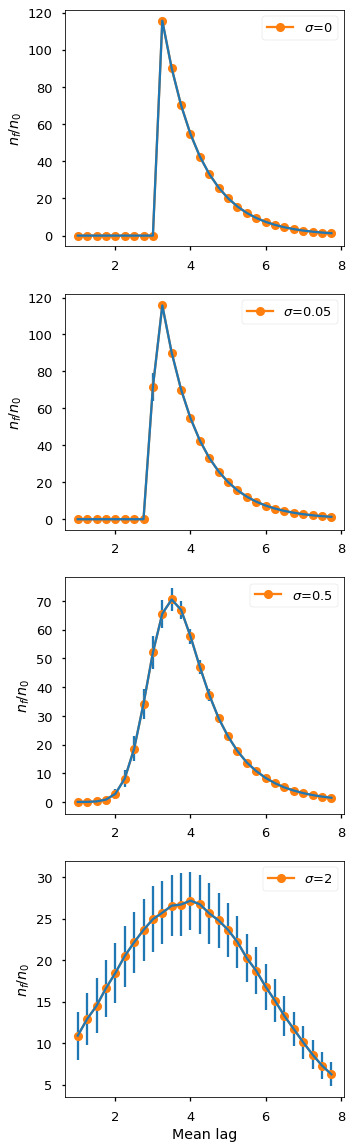

In [59]:
fig, axs = plt.subplots(nrows=len(STs), ncols=1, figsize=(5,20))
for i in range(len(STs)):
    axs[i].errorbar(MTs, MN[:,i]/n0, np.sqrt(VN[:,i])/n0)
    axs[i].plot(MTs, MN[:,i]/n0, 'o-', label = "$\sigma$="+str(STs[i]))
    axs[i].legend()
    axs[i].set_ylabel('$n_f/n_0$')
# fig.legend()
plt.xlabel('Mean lag')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


Text(0.5,0,'Mean lag')

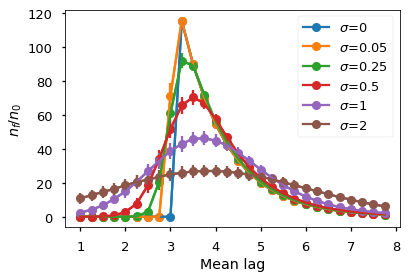

In [6]:
for i in range(len(STs)):
    plt.errorbar(MTs, MN[:,i]/n0, np.sqrt(VN[:,i])/n0, color="C"+str(i))
    plt.plot(MTs, MN[:,i]/n0, 'o-', label = "$\sigma$="+str(STs[i]), color="C"+str(i))
plt.ylabel('$n_f/n_0$')
plt.legend()
# fig.legend()
plt.xlabel('Mean lag')

In [175]:
#Indices of E(T_s) values for max fitness as a function of std
max_MTs_vs_std = np.argmax(MN, axis=0)
#Indices of std(T_s) values for max fitness as a function of E(T_s)
max_STs_vs_mean = np.argmax(MN, axis=1)

40

Text(0.5,1,'$t_a=$3')

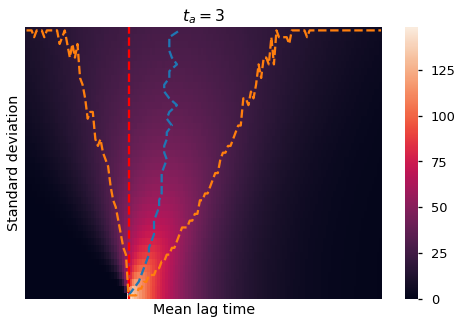

In [176]:
plt.figure(figsize=(8,5))
y_conv = np.arange(len(max_MTs_vs_std))
plt.plot(max_MTs_vs_std+0.5, y_conv+0.5, '--')
x_conv = np.arange(len(max_STs_vs_mean))
plt.plot(x_conv+0.5, max_STs_vs_mean+0.5, '--')
# ax = sns.heatmap(MN.T/n0, yticklabels=STs, xticklabels=MTs)
ax = sns.heatmap(MN.T/n0, yticklabels=False, xticklabels=False)
plt.vlines(np.where(abs(MTs-3) <= 0.05/2)[0][0]+0.5, 0,len(y_conv), color='r', linestyles='--')
ax.invert_yaxis()
plt.ylabel('Standard deviation')
plt.xlabel('Mean lag time')
plt.title('$t_a=$'+str(mTa))

Text(0,0.5,'$\\sigma(T_s)$ for max. fitness')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


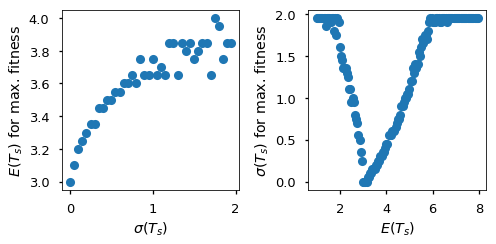

In [151]:
fig, axs = plt.subplots(1,2, figsize=(7,3.5), tight_layout=True)

axs[0].plot(STs, MTs[max_MTs_vs_std], 'o')
axs[0].set_xlabel('$\sigma(T_s)$')
axs[0].set_ylabel('$E(T_s)$ for max. fitness')

axs[1].plot(MTs, [STs[e] for e in max_STs_vs_mean], 'o')
axs[1].set_xlabel('$E(T_s)$')
axs[1].set_ylabel('$\sigma(T_s)$ for max. fitness')

If $t_a$ is fixed. The mean lag time

This may be a result. If the duration of Antibiotic remains constant at a value $T_a$. Under the presence of noise in lag times, the mean lag time for maximum fitness will be greater than $T_a$. It will become larger the larger the (fixed) variance is, but it will probably go down as $T_f$ decreases. In other words, the longer $T_f$ is, the longer the interval in which the fitness will increase.

Let's see what happens when if everything is fixed, we only increase $t_g$

Text(0.5,0,'Mean lag')

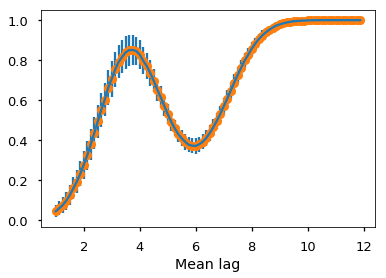

In [21]:
MTs = np.arange(1,12,0.125)
STs = [1]
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa, k=1000, n0=100, tg=4)
plt.errorbar(MTs, MN/n0, np.sqrt(VN)/n0)
plt.plot(MTs, MN/n0, 'o-')
plt.xlabel('Mean lag')

This is interesting, it means that it better to not start growing at all when the Tg is too short!
So short that the growth cannot compensate for the cells that were killed early during treatment

Text(0.5,0,'Mean lag')

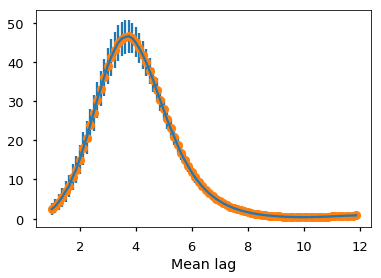

In [22]:
MTs = np.arange(1,12,0.125)
STs = [1]
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa, k=1000, n0=100, tg=8)
plt.errorbar(MTs, MN/n0, np.sqrt(VN)/n0)
plt.plot(MTs, MN/n0, 'o-')
plt.xlabel('Mean lag')

Text(0.5,0,'Mean lag')

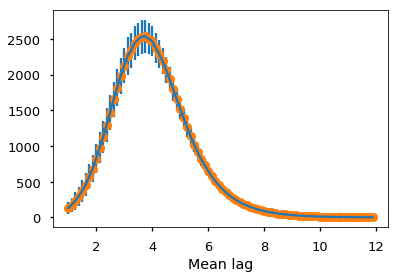

In [23]:
MTs = np.arange(1,12,0.125)
STs = [1]
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa, k=1000, n0=100, tg=12)
plt.errorbar(MTs, MN/n0, np.sqrt(VN)/n0)
plt.plot(MTs, MN/n0, 'o-')
plt.xlabel('Mean lag')

In [93]:
## RUN THE SIMULATIONS!! (tg = 4!)
MTs = np.arange(1,12,0.25)
STs = [0, 0.05, 0.25, 0.5, 1, 2]
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa=0, k=1000, n0=100, tg=4)

In [94]:
#Indices of E(T_s) values for max fitness as a function of std
max_MTs_vs_std = np.argmax(MN, axis=0)
#Indices of std(T_s) values for max fitness as a function of E(T_s)
max_STs_vs_mean = np.argmax(MN, axis=1)

Text(0.5,1,'$t_a=$3')

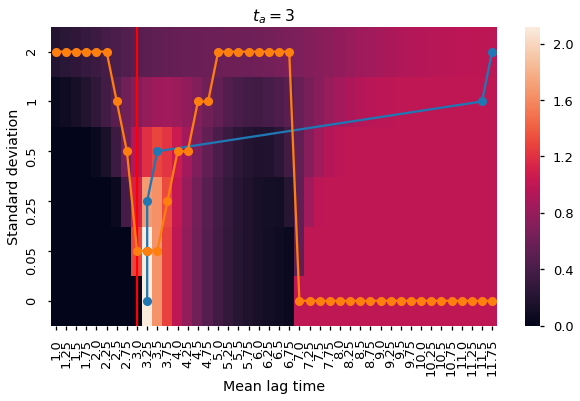

In [97]:
plt.figure(figsize=(10,5.5))
y_conv = np.arange(len(max_MTs_std))
plt.plot(max_MTs_vs_std+0.5, y_conv+0.5, '-o')
x_conv = np.arange(len(max_STs_vs_mean))
plt.plot(x_conv+0.5, max_STs_vs_mean+0.5, '-o')
ax = sns.heatmap(MN.T/n0, yticklabels=STs, xticklabels=MTs)
plt.vlines(np.where(MTs==3)[0]+0.5, 0,len(y_conv), color='r')
ax.invert_yaxis()
plt.ylabel('Standard deviation')
plt.xlabel('Mean lag time')
plt.title('$t_a=$'+str(mTa))

This shows that when the time for growth is small and the variability in lag times is constrained to be relatively large, it is better to not grow at all. This occurs because due to variability many cells will start growing before the antibiotic is gone, so many of them will die, and the short time for growth (nutrient supply) is not enough for the population to grow and compensate for that loss.

### 2019/03/20

It seems like, for a fixed (deterministic) duration of antibiotic exposure, the mean lag for maximum fitness depends on the variance in lag times, shorter variance yield a maximum that is closer to $T_a$, while a longer variance makes it larger. I think in this case it makes a lot of sense to have a skewed distribution.

Now, let's see what happens when we introduce variability in the antibiotic duration times.

In [164]:
## RUN THE SIMULATIONS!!
MTs = np.arange(1,8,0.05)
STs = np.arange(0,2,0.05)

start = time.time()
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa=0.25, k=1000, n0=100, tg=8)
end = time.time()
print(sec_to_ms(end-start))

30:44.914610147476196


Text(0.5,1,'$t_a=$3')

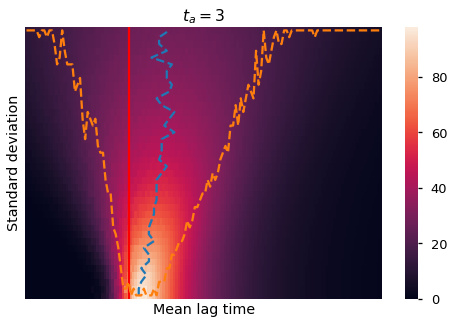

In [169]:
#Indices of E(T_s) values for max fitness as a function of std
max_MTs_vs_std = np.argmax(MN, axis=0)
#Indices of std(T_s) values for max fitness as a function of E(T_s)
max_STs_vs_mean = np.argmax(MN, axis=1)

plt.figure(figsize=(8,5))
y_conv = np.arange(len(max_MTs_vs_std))
plt.plot(max_MTs_vs_std+0.5, y_conv+0.5, '--')
x_conv = np.arange(len(max_STs_vs_mean))
plt.plot(x_conv+0.5, max_STs_vs_mean+0.5, '--')
# ax = sns.heatmap(MN.T/n0, yticklabels=STs, xticklabels=MTs)
ax = sns.heatmap(MN.T/n0, yticklabels=False, xticklabels=False)

plt.vlines(np.where(abs(MTs-3) <= 0.05/2)[0][0]+0.5, 0,len(y_conv), color='r')
ax.invert_yaxis()
plt.ylabel('Standard deviation')
plt.xlabel('Mean lag time')
plt.title('$t_a=$'+str(mTa))

Text(0,0.5,'$\\sigma(T_s)$ for max. fitness')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


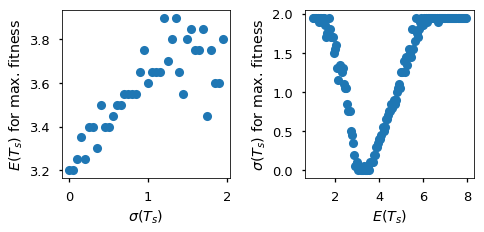

In [173]:
fig, axs = plt.subplots(1,2, figsize=(7,3.5), tight_layout=True)

axs[0].plot(STs, MTs[max_MTs_vs_std], 'o')
axs[0].set_xlabel('$\sigma(T_s)$')
axs[0].set_ylabel('$E(T_s)$ for max. fitness')

axs[1].plot(MTs, [STs[e] for e in max_STs_vs_mean], 'o')
axs[1].set_xlabel('$E(T_s)$')
axs[1].set_ylabel('$\sigma(T_s)$ for max. fitness')

In [177]:
np.save('./arrays/exp_002_MN', MN)
np.save('./arrays/exp_002_VN', VN)
np.save('./arrays/exp_002_MTs', MTs)
np.save('./arrays/exp_002_STs', STs)

Text(0.5,1,'$t_a=$3')

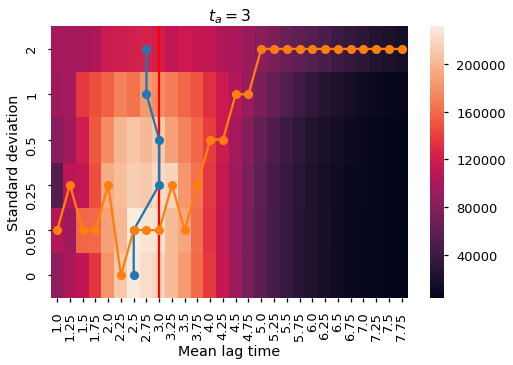

In [109]:
## RUN THE SIMULATIONS!!
MTs = np.arange(1,8,0.25)
STs = [0, 0.05, 0.25, 0.5, 1, 2]
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa=mTa/3, k=1000, n0=100, tg=16)

#Indices of E(T_s) values for max fitness as a function of std
max_MTs_vs_std = np.argmax(MN, axis=0)
#Indices of std(T_s) values for max fitness as a function of E(T_s)
max_STs_vs_mean = np.argmax(MN, axis=1)

plt.figure(figsize=(8,5))
y_conv = np.arange(len(max_MTs_std))
plt.plot(max_MTs_vs_std+0.5, y_conv+0.5, '-o')
x_conv = np.arange(len(max_STs_vs_mean))
plt.plot(x_conv+0.5, max_STs_vs_mean+0.5, '-o')
ax = sns.heatmap(MN.T/n0, yticklabels=STs, xticklabels=MTs)
plt.vlines(np.where(MTs==3)[0]+0.5, 0,len(y_conv), color='r')
ax.invert_yaxis()
plt.ylabel('Standard deviation')
plt.xlabel('Mean lag time')
plt.title('$t_a=$'+str(mTa))

So it seems like it is better to reduce the mean lag time in the presence of variability in $T_a$! This is a surprising result! It can be explained by the fact that since it is so noisy. The risk for going to lower values is compensated by the gain of more growing cells when the sampled $T_a$ is small! This is not what I was expecting!

Text(0.5,0,'Mean lag')

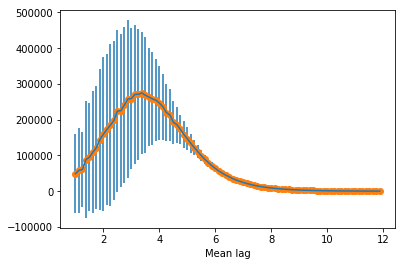

In [11]:
MTs = np.arange(1,12,0.125)
STs = [1]
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa=mTa/5, k=1000, n0=100, tg=12)
plt.errorbar(MTs, MN, np.sqrt(VN))
plt.plot(MTs, MN, 'o-')
plt.xlabel('Mean lag')

Text(0.5,0,'Mean lag')

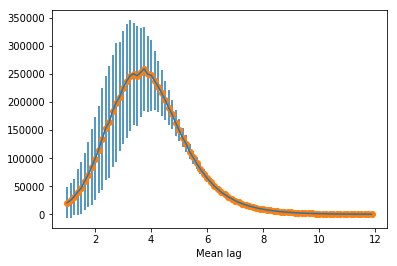

In [13]:
MTs = np.arange(1,12,0.125)
STs = [1]
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa=mTa/10, k=1000, n0=100, tg=12)
plt.errorbar(MTs, MN, np.sqrt(VN))
plt.plot(MTs, MN, 'o-')
plt.xlabel('Mean lag')

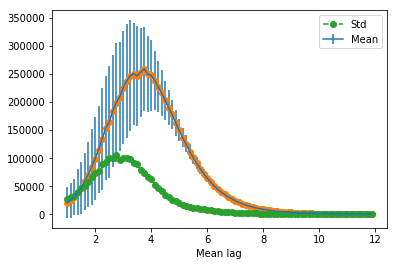

In [19]:
plt.errorbar(MTs, MN, np.sqrt(VN), label='Mean')
plt.plot(MTs, MN, 'o-')
plt.plot(MTs, np.sqrt(VN), 'o--', label='Std')
plt.xlabel('Mean lag')
plt.legend()

See what happens between the two peaks.

STORY:

A skewed distribution makes more sense: It matches with what has been observed in Balaban's paper, and one can think of biological mechanisms that can give rise to that kind of distribution for waiting times (such as a Gamma distribution is determined by the sum of multiple exponential steps).

READ about active regulation of gene expression variability

Text(0.5,0,'Mean lag')

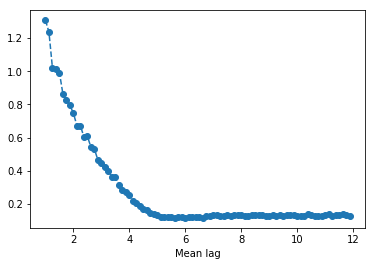

In [15]:
plt.plot(MTs, np.sqrt(VN)/MN, 'o--')
plt.xlabel('Mean lag')

There is a huge variability in the final population when there is variability in $T_a$ also. It will decrease as $\sigma_{T_a}$ decreases. Given those huges error bars, one may wonder: Is it worth it to optimize for the maximum mean?

Think about this in terms of:
- the probability of extinction, 
- or the probability of reaching a final population over a certain number. Maybe we can plot that probability as a function of the number.
- The difference between a tightly regulated distribution vs. something that requires more regulation, and it is suboptimal in the mean, but it is not much worse given the huge variability.
- In general, we can think of the whole problem in the following sense: How much worse is a suboptimal strategy vs. the most optimal one? ASK/THINK Is there a metric for fitness that takes into accout this variability?

### Lets generate histograms for N

In [21]:
MTs = np.arange(1,12,0.125)
STs = [1]
NN, N_SURV, N_NGROW = sample_Ts_statistics_long(MTs, STs, mTa, sTa, k=1000, n0=100, tg=12)
# plt.errorbar(MTs, MN, np.sqrt(VN))
# plt.plot(MTs, MN, 'o-')
# plt.xlabel('Mean lag')

def compute_statistics_long():
    '''
    Finds the statistics for when I ran the long version of the simulation
    i.e. the one that returns all values of N.
    '''
    

In [23]:
def find_nearest(array, value):
    '''
    Finds the nearest element index (and element) of an array to a given value
    '''
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

idx, _ = find_nearest(MTs, 3.8)
idx

22

In [24]:
shape(NN)

(88, 1, 1000)

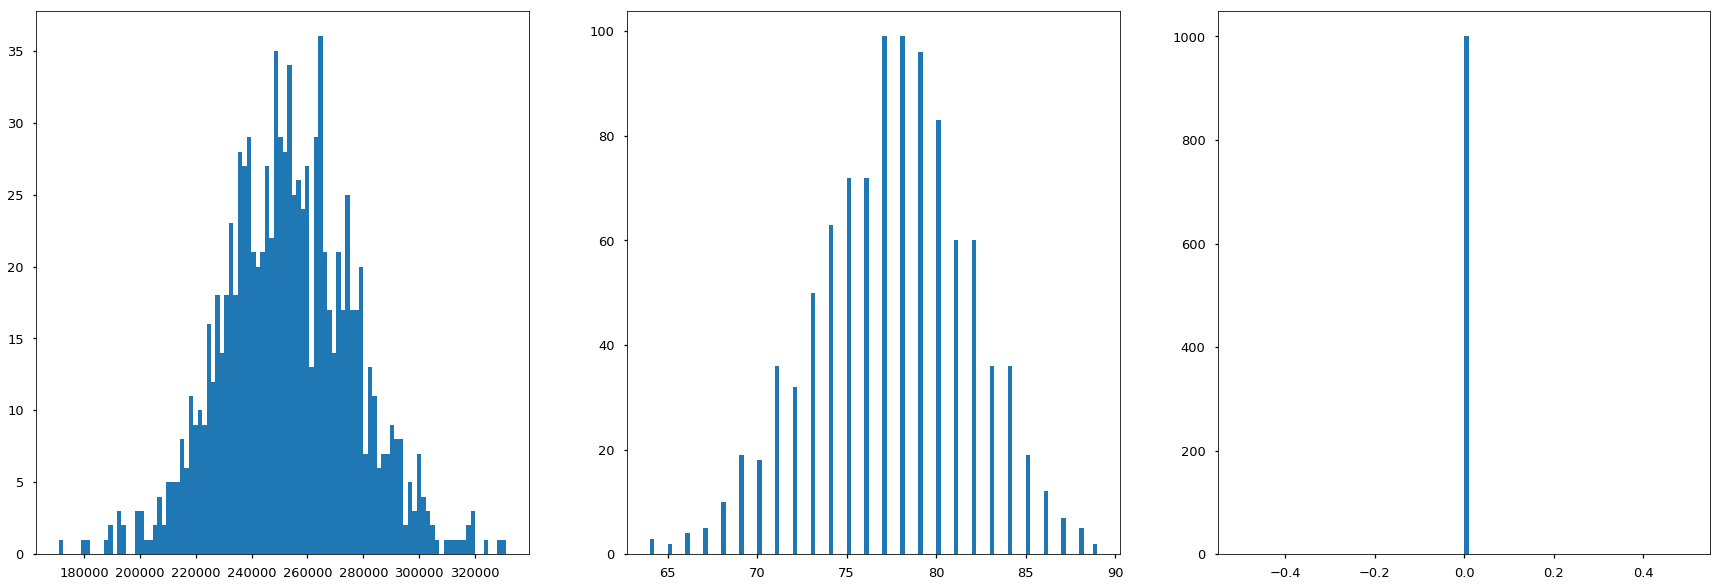

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(30,10))
_ = axs[0].hist(NN[22,0,:], bins=100)
_ = axs[1].hist(N_SURV[22,0,:], bins=100)
_ = axs[2].hist(N_NGROW[22,0,:], bins=100)

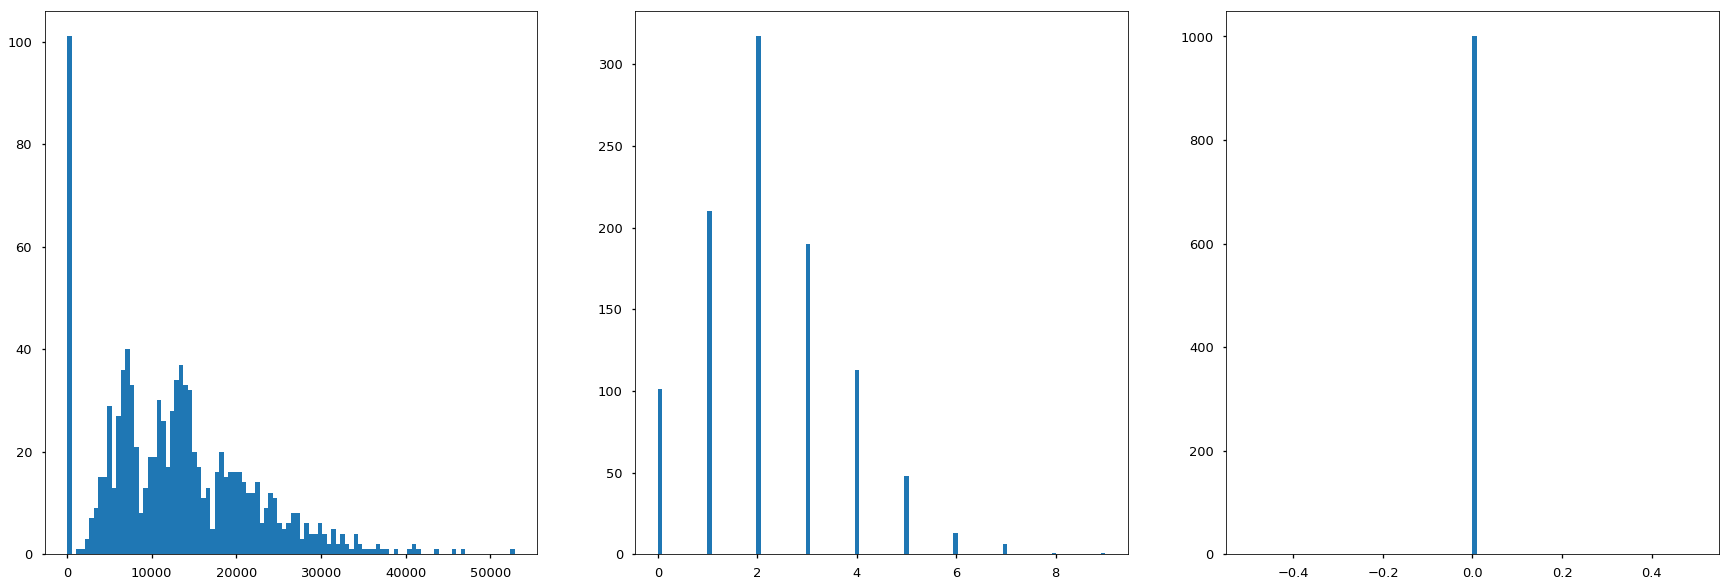

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(30,10))
_ = axs[0].hist(NN[0,0,:], bins=100)
_ = axs[1].hist(N_SURV[0,0,:], bins=100)
_ = axs[2].hist(N_NGROW[0,0,:], bins=100)

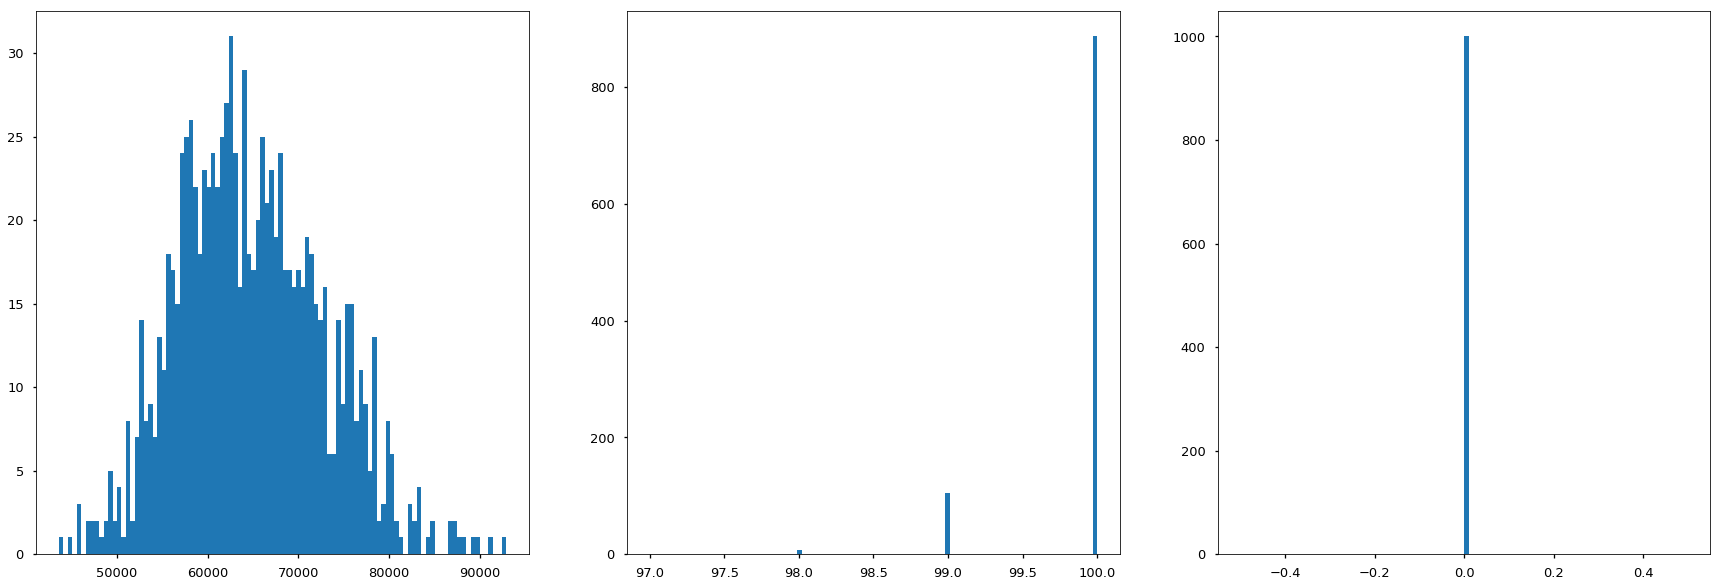

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(30,10))
_ = axs[0].hist(NN[40,0,:], bins=100)
_ = axs[1].hist(N_SURV[40,0,:], bins=100)
_ = axs[2].hist(N_NGROW[40,0,:], bins=100)

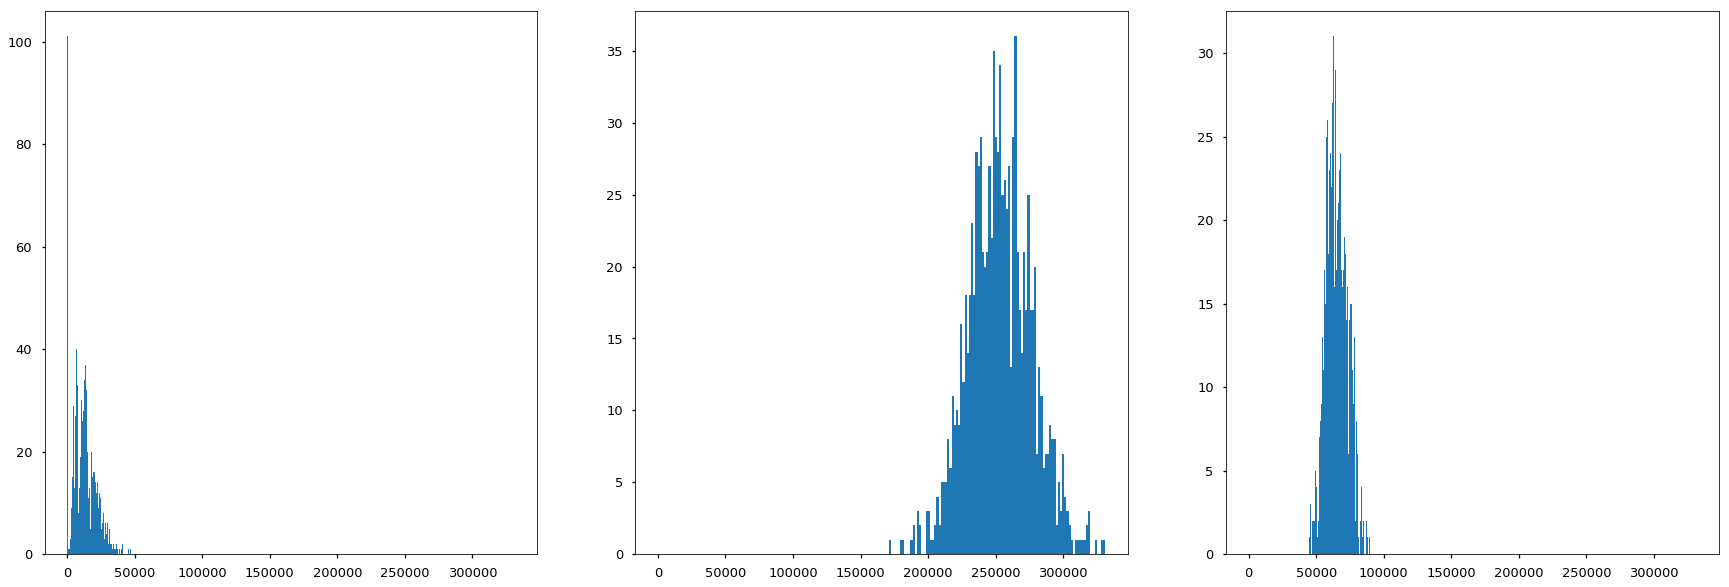

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(30,10))
_ = axs[0].hist(NN[0,0,:], bins=100)
_ = axs[1].hist(NN[22,0,:], bins=100)
_ = axs[2].hist(NN[40,0,:], bins=100)

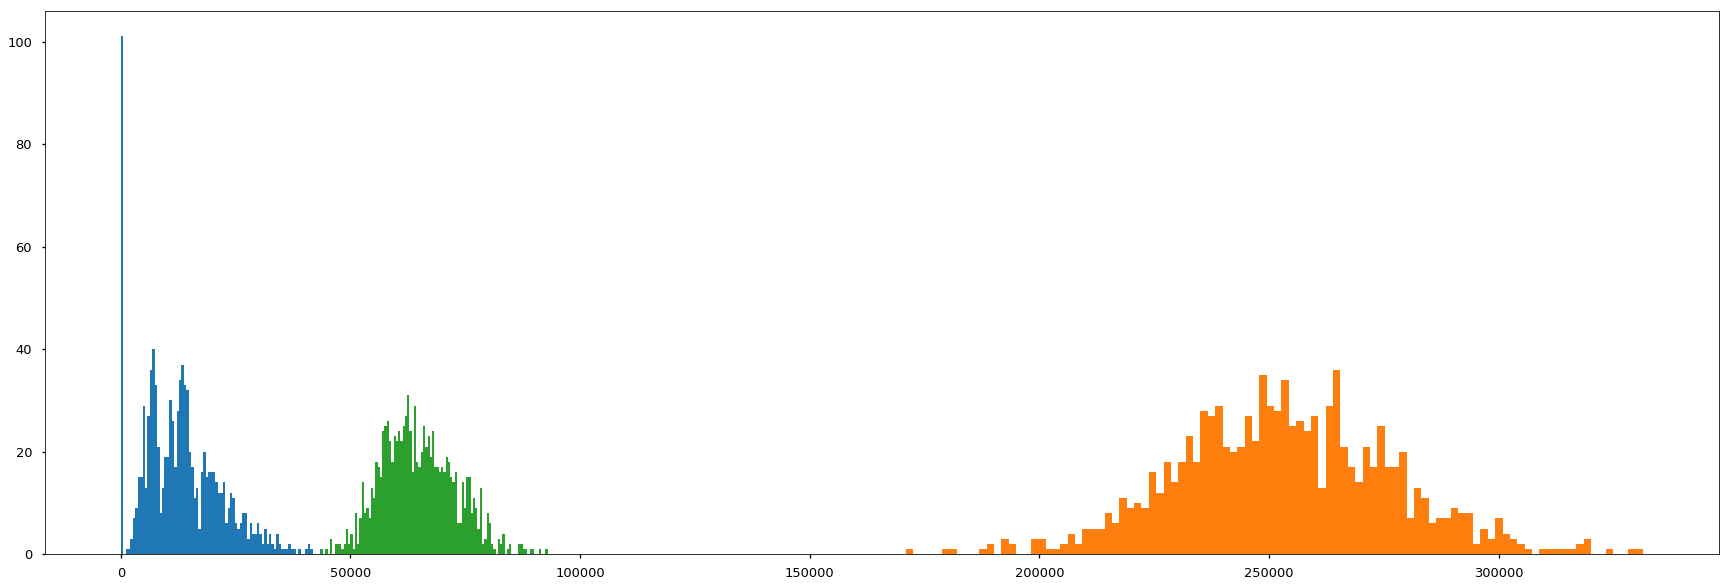

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(30,10))
_ = axs.hist(NN[0,0,:], bins=100)
_ = axs.hist(NN[22,0,:], bins=100)
_ = axs.hist(NN[40,0,:], bins=100)

I think I essentially have all the pipeline to run this. Now it is a matter of choosing the right parameters.

### 2019/03/29 
The distributions in Balaban are definitely skewed. For all the values of $t_a$, the median is larger than the mean. According to:

https://stats.stackexchange.com/questions/72381/gamma-vs-lognormal-distributions

The gamma and lognormal have been used to model the same kind of phenomena. They are both skewed, with slight differences in how fat are the left and right tails. However, they seem to be very subtle, and given the huge variability in fitness that occurs by default, it shouldn't make a big difference to choose one or the other.

### 2019/03/30
Analysis of execution time in my PC: Let $T$ be the execution time.

$T$ should not scale with $t_g$ given that the cells are killed as soon as they start growing (if I introduce probabilistic killing it will affect it).

$T \propto k$. The number of runs to get statistics.
$T \propto N0$. The larger is the initial number of cells, the more lag times have to be assigned, and the larger is the number of comparisons between $t_s and t_a$ that have to be done, and the time evolution for the larger cells.

$ T\propto$ len(MTs), len(STs). The more parameters are screened.

Summarizing

$$ T \propto \text{len(MTs)}\cdot \text{len(STs)} \cdot k \cdot N_0 $$

This is for a single $t_g$ and $t_a$. I would have to multiply for the lengths of the lists for each one of them if I plan to screen them too.

$T$ will also increase if I save the entire list of fitness values for every experiment vs. saving only the statistics. 

This one:

```
MTs = np.arange(1,8,0.05)
STs = np.arange(0,2,0.05)

start = time.time()
MN, VN = sample_Ts_statistics(MTs, STs, mTa, sTa=1, k=1000, n0=100, tg=8)
```

took 24 minutes, and it is very noisy (I cannot draw any specific conclusions by looking at the max lines :(( . However, it seems that the area of large fitness is larger and more shifted towards smaller values of mean $T_s$. 

To reduce the noise, I must run it with either larger $N_0$, or larger $k$. However, if I increase either one 10-fold, I will get $240$ mins = $4$ hours run time, and this is still probably not good enough. I have to parallelize it.

Let's say SEM scales like $\sigma/\sqrt{k}$. Then, to be able to reduce it to the order of 